In [1]:
# Data management
import pandas as pd
import json
from pandas.io.json import json_normalize
from pandas.plotting import scatter_matrix
from datetime import datetime

# Math and Stat modules
import numpy as np
from scipy.stats import sem
from random import choice

# Data preprocessing and trasformation (ETL)
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, FunctionTransformer, Binarizer, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml, load_iris, make_moons, make_classification

# Supervised Learning
from sklearn.model_selection import train_test_split,cross_validate, cross_val_score, cross_val_predict, KFold, StratifiedKFold, RepeatedKFold, ShuffleSplit, StratifiedShuffleSplit, learning_curve, validation_curve
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.utils import class_weight
from tensorflow import keras
import tensorflow as tf
import tensorflow_hub as hub

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.tree import export_graphviz
%matplotlib inline

In [2]:
# date unix conversion
def date_f(unix_d):
    d = datetime.utcfromtimestamp(unix_d).strftime('%Y-%m-%d %H:%M:%S')
    d1 = datetime.strptime(d, '%Y-%m-%d %H:%M:%S')
    return d1

# cross-validation model
def valuta_modello(X, y, model, n_splits=5, shuffle=True):
    # non avendo comunque un grande sbilanciamento procedo solo con la StratifiedKfold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle)
    s = ['accuracy', 'precision', 'recall', 'f1']
    print('\n {}'.format(skf))
    scores = cross_validate(model, X, y, scoring=s, cv=skf, n_jobs=-1)
    y_train_predicted = cross_val_predict(model, X, y, cv=skf)
    for j in s:
        print('>scoring={} mean={:.4f} se={:.3f}'.format(j, np.mean(scores[('test_'+ j)]), sem(scores[('test_'+ j)])))
    print('\n confusion matrix \n {}'.format(confusion_matrix(y, y_train_predicted)))

# embedding sentences
def embedding_text(t, model):
    blurb_l = t.values.tolist()
    sentence_embeddings = np.asmatrix(model(blurb_l).numpy())
    return sentence_embeddings

## Caricamento dataset e selezione features

In [3]:
data = [json.loads(line) for line in open('data3/Kickstarter_2021-01-14T03_20_05_328Z.json', 'r', encoding="utf8")]
data = pd.json_normalize(data)

In [4]:
# keep only the useful columns
ks = data.iloc[: , [3, 13, 14, 15, 17, 25, 28, 32, 59, 64, 68]]

# rename columns
ks = ks.rename(lambda x: x.replace(".", "_"), axis=1)
ks = ks.rename(lambda x: x.replace("data_", ""), axis=1)

# remove records in the columns 'state' with value 'live' and 'canceled'
ks = ks[ks.state != 'live']
ks = ks[ks.state != 'canceled']

# remove records in the columns 'id' with value duplicate
ks = ks.drop_duplicates('id')

# conversion of unix date
ks['deadline'] = ks['deadline'].apply(date_f)
ks['launched_at'] = ks['launched_at'].apply(date_f)

# create a column with only the days relating to the funding period
ks['funding_period'] = (ks['deadline']-ks['launched_at']).dt.days

# create two columns with only the months related to the date of columns 'deadline' and 'launched_at'
ks['deadline_month'] = ks['deadline'].dt.month
ks['launched_at_month'] = ks['launched_at'].dt.month

# conversion of the 'goal' currency in USD
ks['goal'] = ks['goal']*ks['static_usd_rate']

# create two columns with the length of value in the columns 'name' and 'blurb'
ks['name_l'] = ks['name'].str.len()
ks['blurb_l'] = ks['blurb'].str.len()

# remove the null values from the column 'location_expanded_country' and reset the index
ks.dropna(subset=['location_expanded_country'], inplace=True)
ks.dropna(subset=['category_parent_name'], inplace=True)
ks = ks.reset_index(drop=True)

In [5]:
# extract the label column and remove it from the dataset along with non-useful columns
ks_label1 = ks['state'].map(
    {'failed':0,
     'successful':1
    }
)
ks1 = ks.drop(['id', 'name', 'blurb', 'state', 'deadline', 'launched_at', 'static_usd_rate'], axis=1)

In [6]:
ks1.columns = ['goal', 'country', 'main_category', 'sec_category', 'funding_period', 'deadline_month', 'launched_month', 'name_l', 'descr_l']

In [7]:
ks1.head()

,goal,country,main_category,sec_category,funding_period,deadline_month,launched_month,name_l,descr_l
0,5227.00000,United States,Community Gardens,Food,29,4,3,29,123
1,46282.03230,United Kingdom,Drama,Film & Video,30,8,7,15,119
2,1000.00000,United States,Playing Cards,Games,30,7,6,55,133
3,1019.89432,Hong Kong,Playing Cards,Games,30,10,9,31,30
4,550.00000,United States,Textiles,Art,30,2,1,27,124


## Analisi dataset

In [8]:
print(ks_label1.value_counts())
print(ks_label1.value_counts(normalize=True))

1    98965
0    75032
Name: state, dtype: int64
1    0.568774
0    0.431226
Name: state, dtype: float64


In [9]:
ks1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173997 entries, 0 to 173996
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   goal            173997 non-null  float64
 1   country         173997 non-null  object 
 2   main_category   173997 non-null  object 
 3   sec_category    173997 non-null  object 
 4   funding_period  173997 non-null  int64  
 5   deadline_month  173997 non-null  int64  
 6   launched_month  173997 non-null  int64  
 7   name_l          173997 non-null  int64  
 8   descr_l         173997 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 11.9+ MB


In [10]:
ks1.describe()

,goal,funding_period,deadline_month,launched_month,name_l,descr_l
count,1.739970e+05,173997.000000,173997.000000,173997.000000,173997.000000,173997.000000
mean,4.069380e+04,32.830445,6.807727,6.495066,34.576700,108.773105
std,1.126513e+06,12.123884,3.352057,3.324701,15.616727,29.417966
min,1.000000e-02,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.500000e+03,29.000000,4.000000,4.000000,21.000000,94.000000
50%,5.000000e+03,30.000000,7.000000,7.000000,34.000000,121.000000
75%,1.280000e+04,35.000000,10.000000,9.000000,48.000000,132.000000
max,1.523501e+08,91.000000,12.000000,12.000000,85.000000,150.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027226A4FA00>,
      dtype=object)

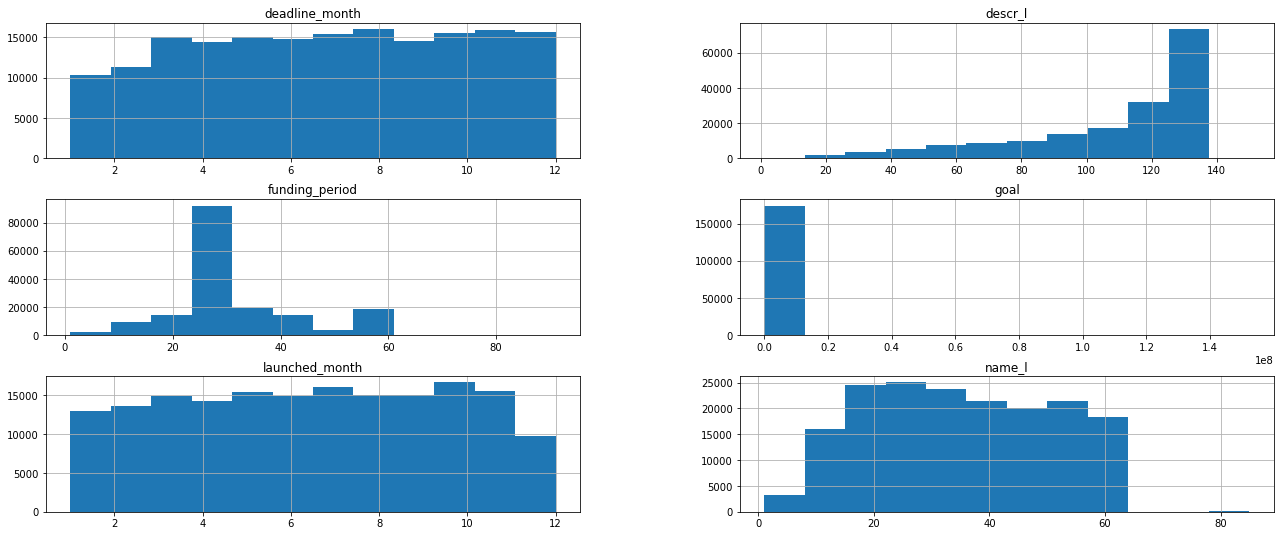

In [11]:
ks1.hist(figsize=(22,9), bins=12)

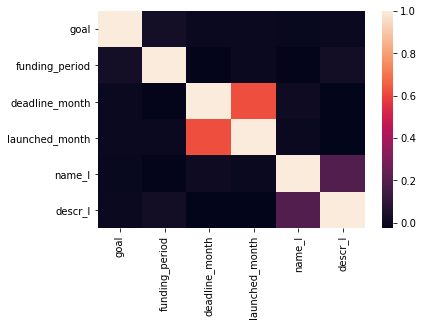

In [12]:
import seaborn as sns
corr = ks1.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

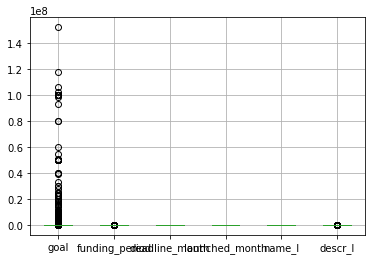

In [13]:
ks1.boxplot()

## Logistic Regression

In [8]:
features_categorical = ['country','main_category','sec_category', 'launched_month', 'deadline_month']
features_robust = ['descr_l','goal','funding_period']
features_standard = ['name_l']

In [15]:
data_preprocessing_lr = ColumnTransformer([
    ('features_categorical', OneHotEncoder(), features_categorical),
    ('numeric_robust', RobustScaler(), features_robust),
    ('feature_standard', StandardScaler(), features_standard)
],
    remainder = 'passthrough'
)

In [16]:
fm = data_preprocessing_lr.fit_transform(ks1)
print(type(fm), fm.shape)

<class 'scipy.sparse.csr.csr_matrix'> (173997, 387)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(fm, ks_label1, test_size=0.3, random_state=45)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((121797, 387), (121797,), (52200, 387), (52200,))

### GridSearch

In [18]:
logit_cls = LogisticRegression(max_iter=1000, n_jobs=-1) 

In [19]:
param_grid_lr = [
    {'penalty': ['l1', 'l2'],
     'class_weight':['balanced', None],
     'solver':['liblinear', 'saga'],
     'C': [0.001, 0.01, 1, 100, 1000]
    }
]

grid_search_lr = GridSearchCV(logit_cls, 
                           param_grid= param_grid_lr,
                           cv=StratifiedKFold(),
                           n_jobs=-1,
                           scoring=['f1','accuracy'],
                           refit = 'f1'
                          )

In [20]:
grid_search_lr.fit(X_train, y_train)

C:\Users\marco\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=1000, n_jobs=-1), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 1, 100, 1000],
                          'class_weight': ['balanced', None],
                          'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'saga']}],
             refit='f1', scoring=['f1', 'accuracy'])

In [21]:
results = pd.DataFrame(grid_search_lr.cv_results_)[['mean_test_f1','params','mean_test_accuracy']]
results.sort_values(by='mean_test_f1',ascending=False)

,mean_test_f1,params,mean_test_accuracy
14,0.787378,"{'C': 0.01, 'class_weight': None, 'penalty': '...",0.755675
22,0.784116,"{'C': 1, 'class_weight': None, 'penalty': 'l2'...",0.762400
30,0.784092,"{'C': 100, 'class_weight': None, 'penalty': 'l...",0.762457
36,0.784080,"{'C': 1000, 'class_weight': None, 'penalty': '...",0.762392
28,0.784021,"{'C': 100, 'class_weight': None, 'penalty': 'l...",0.762326
38,0.783923,"{'C': 1000, 'class_weight': None, 'penalty': '...",0.762252
20,0.783800,"{'C': 1, 'class_weight': None, 'penalty': 'l1'...",0.762219
12,0.779174,"{'C': 0.01, 'class_weight': None, 'penalty': '...",0.749904
6,0.772415,"{'C': 0.001, 'class_weight': None, 'penalty': ...",0.713359
10,0.768372,"{'C': 0.01, 'class_weight': 'balanced', 'penal...",0.755700


In [22]:
print('best score: ',grid_search_lr.best_score_)
print('best params: ',grid_search_lr.best_params_)

best score:  0.7873779399212639
best params:  {'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}


### RandomizedSearch

In [23]:
param_grid_lr_r = [
    {'penalty': ['l1', 'l2'],
     'class_weight':['balanced', None],
     'solver':['liblinear', 'saga'],
     'C': [0.001, 0.01, 1, 100, 1000]
    }
]

random_search_lr = RandomizedSearchCV(logit_cls, 
                           param_distributions= param_grid_lr_r,
                           cv=StratifiedKFold(),
                           n_jobs=-1,
                           scoring=['f1','accuracy'],
                           refit = 'f1'
                          )

In [24]:
random_search_lr.fit(X_train, y_train)

C:\Users\marco\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LogisticRegression(max_iter=1000, n_jobs=-1),
                   n_jobs=-1,
                   param_distributions=[{'C': [0.001, 0.01, 1, 100, 1000],
                                         'class_weight': ['balanced', None],
                                         'penalty': ['l1', 'l2'],
                                         'solver': ['liblinear', 'saga']}],
                   refit='f1', scoring=['f1', 'accuracy'])

In [25]:
results_r = pd.DataFrame(random_search_lr.cv_results_)[['mean_test_f1','params','mean_test_accuracy']]
results_r.sort_values(by='mean_test_f1',ascending=False)

,mean_test_f1,params,mean_test_accuracy
9,0.784114,"{'solver': 'liblinear', 'penalty': 'l1', 'clas...",0.762424
7,0.762925,"{'solver': 'liblinear', 'penalty': 'l1', 'clas...",0.757408
1,0.756450,"{'solver': 'liblinear', 'penalty': 'l2', 'clas...",0.723310
0,0.687562,"{'solver': 'saga', 'penalty': 'l1', 'class_wei...",0.633989
6,0.685423,"{'solver': 'liblinear', 'penalty': 'l1', 'clas...",0.640426
4,0.642843,"{'solver': 'saga', 'penalty': 'l2', 'class_wei...",0.619802
5,0.642837,"{'solver': 'saga', 'penalty': 'l1', 'class_wei...",0.619802
8,0.642837,"{'solver': 'saga', 'penalty': 'l1', 'class_wei...",0.619802
2,0.642827,"{'solver': 'saga', 'penalty': 'l2', 'class_wei...",0.619785
3,0.642720,"{'solver': 'saga', 'penalty': 'l2', 'class_wei...",0.619695


In [26]:
print('best score: ',random_search_lr.best_score_)
print('best params: ',random_search_lr.best_params_)

best score:  0.7841135501207501
best params:  {'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None, 'C': 1000}


### Validation best params

In [115]:
logit_cls_bp = LogisticRegression(max_iter=1000,
                                  n_jobs=-1,
                                  C=0.01,
                                  class_weight=None,
                                  penalty= 'l2',
                                  random_state=1,
                                  solver='liblinear') 

In [116]:
train_sizes, train_scores, test_scores = learning_curve(logit_cls_bp,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.1,1.0,10),
                                                       cv=StratifiedKFold(random_state=1, shuffle=True),
                                                       n_jobs=-1)

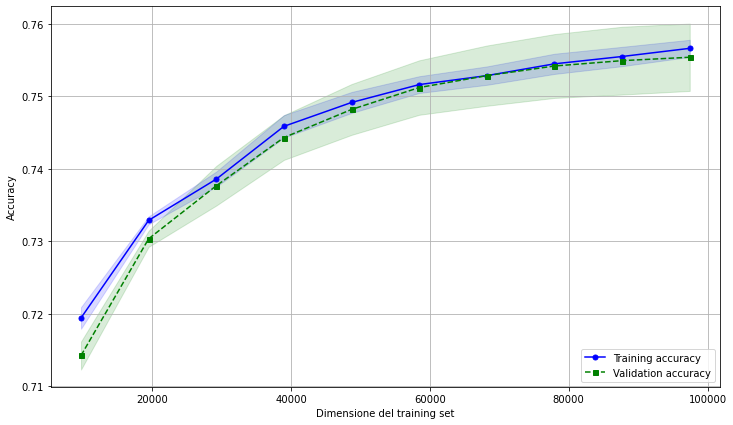

In [117]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Dimensione del training set')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right')

In [118]:
print("accuracy:", round(train_mean[-1], 4), "- val_accuracy:", round(test_mean[-1], 4))

accuracy: 0.7566 - val_accuracy: 0.7554


C:\Users\marco\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


val_accuracy: 0.7554


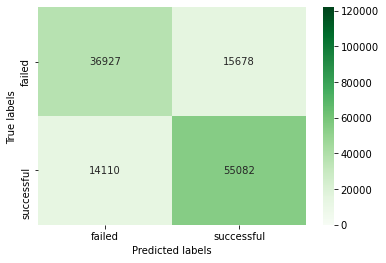

In [127]:
y_train_p_lr = cross_val_predict(logit_cls_bp, X_train, y_train, cv=StratifiedKFold(random_state=1, shuffle=True))
print('val_accuracy:', round(accuracy_score(y_train, y_train_p_lr), 4))

cm_c_lr = confusion_matrix(y_train, y_train_p_lr)
ax= plt.subplot()
sns.heatmap(cm_c_lr, annot=False, ax = ax, cmap="Greens", vmin=0, vmax=sum(sum(cm_c_lr))); #annot=True to annotate cells
sns.heatmap(cm_c_lr, annot=cm_c_lr, fmt="", cbar=False, cmap="Greens", vmin=0, vmax=sum(sum(cm_c_lr)))

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
#ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['failed', 'successful']); ax.yaxis.set_ticklabels(['failed', 'successful']);


### Test result

In [122]:
logit_cls_bp.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=1000, n_jobs=-1, random_state=1,
                   solver='liblinear')

Accuracy SCore 0.7532375478927203
F1 SCore 0.7532450019349787
Precision Score 0.7532525233176227
Recall SCore 0.7532375478927203


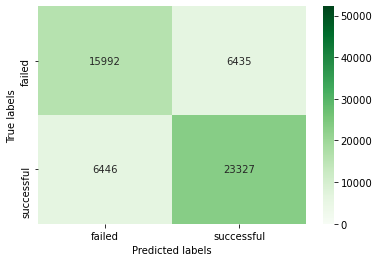

In [128]:
y_pred_lr = logit_cls_bp.predict(X_test)
print("Accuracy SCore", accuracy_score(y_test, y_pred_lr))
print("F1 SCore", f1_score(y_test, y_pred_lr, average='weighted'))
print("Precision Score", precision_score(y_test, y_pred_lr, average='weighted'))
print("Recall SCore", recall_score(y_test, y_pred_lr, average='weighted'))
cm = confusion_matrix(y_test, y_pred_lr)
ax= plt.subplot()
sns.heatmap(cm, annot=False, ax = ax, cmap="Greens", vmin=0, vmax=sum(sum(cm))); #annot=True to annotate cells
sns.heatmap(cm, annot=cm, fmt="", cbar=False, cmap="Greens", vmin=0, vmax=sum(sum(cm)))

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
#ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['failed', 'successful']); ax.yaxis.set_ticklabels(['failed', 'successful']);

## Random Forest

In [32]:
ks1.head()

,goal,country,main_category,sec_category,funding_period,deadline_month,launched_month,name_l,descr_l
0,5227.00000,United States,Community Gardens,Food,29,4,3,29,123
1,46282.03230,United Kingdom,Drama,Film & Video,30,8,7,15,119
2,1000.00000,United States,Playing Cards,Games,30,7,6,55,133
3,1019.89432,Hong Kong,Playing Cards,Games,30,10,9,31,30
4,550.00000,United States,Textiles,Art,30,2,1,27,124


In [33]:
data_preprocessing_rf = ColumnTransformer([
    ('features_categorical', OneHotEncoder(), features_categorical),
    #('numeric_robust', RobustScaler(), features_robust),
    #('feature_standard', StandardScaler(), features_standard)
],
    remainder = 'passthrough'
)

In [34]:
fm1 = data_preprocessing_rf.fit_transform(ks1)
print(type(fm1), fm1.shape)

<class 'scipy.sparse.csr.csr_matrix'> (173997, 387)


In [35]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(fm1, ks_label1, test_size=0.3, random_state=45)
X_train_rf.shape, X_test_rf.shape, y_train_rf.shape, y_test_rf.shape

((121797, 387), (52200, 387), (121797,), (52200,))

### GridSearch

In [36]:
rf_cls = RandomForestClassifier(n_jobs=-1)

In [37]:
param_grid_rf = [
    {'max_features': ['auto', 'sqrt'],
     'max_depth':[8, 24, 48, None],
     'n_estimators':[50, 150, 300],
     'bootstrap': [True, False]
    }
]
grid_search_rf = GridSearchCV(rf_cls, 
                           param_grid= param_grid_rf,
                           cv=StratifiedKFold(),
                           n_jobs=-1,
                           scoring=['f1','accuracy'],
                           refit = 'f1'
                          )

In [38]:
grid_search_rf.fit(X_train_rf, y_train_rf)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid=[{'bootstrap': [True, False],
                          'max_depth': [8, 24, 48, None],
                          'max_features': ['auto', 'sqrt'],
                          'n_estimators': [50, 150, 300]}],
             refit='f1', scoring=['f1', 'accuracy'])

In [39]:
results_rf = pd.DataFrame(grid_search_rf.cv_results_)[['mean_test_f1','params','mean_test_accuracy']]
results_rf.sort_values(by='mean_test_f1',ascending=False)

,mean_test_f1,params,mean_test_accuracy
14,0.797609,"{'bootstrap': True, 'max_depth': 48, 'max_feat...",0.768369
17,0.797546,"{'bootstrap': True, 'max_depth': 48, 'max_feat...",0.768278
16,0.796982,"{'bootstrap': True, 'max_depth': 48, 'max_feat...",0.767507
13,0.796856,"{'bootstrap': True, 'max_depth': 48, 'max_feat...",0.767646
15,0.795253,"{'bootstrap': True, 'max_depth': 48, 'max_feat...",0.765076
38,0.795070,"{'bootstrap': False, 'max_depth': 48, 'max_fea...",0.764994
41,0.794698,"{'bootstrap': False, 'max_depth': 48, 'max_fea...",0.764789
37,0.794591,"{'bootstrap': False, 'max_depth': 48, 'max_fea...",0.764649
12,0.794089,"{'bootstrap': True, 'max_depth': 48, 'max_feat...",0.764255
40,0.793898,"{'bootstrap': False, 'max_depth': 48, 'max_fea...",0.763968


In [40]:
print('best score: ',grid_search_rf.best_score_)
print('best params: ',grid_search_rf.best_params_)

best score:  0.7976094474492472
best params:  {'bootstrap': True, 'max_depth': 48, 'max_features': 'auto', 'n_estimators': 300}


### Randomized search

In [56]:
param_grid_rf_r = [
    {'max_features': ['auto', 'sqrt'],
     'max_depth':[8, 24, 48, None],
     'n_estimators':[50, 150, 300],
     'bootstrap': [True, False]
    }
]

random_search_rf = RandomizedSearchCV(rf_cls, 
                           param_distributions= param_grid_rf_r,
                           cv=StratifiedKFold(),
                           n_jobs=-1,
                           scoring=['f1','accuracy'],
                           refit = 'f1'
                          )

In [57]:
random_search_rf.fit(X_train_rf, y_train_rf)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
                   param_distributions=[{'bootstrap': [True, False],
                                         'max_depth': [8, 24, 48, None],
                                         'max_features': ['auto', 'sqrt'],
                                         'n_estimators': [50, 150, 300]}],
                   refit='f1', scoring=['f1', 'accuracy'])

In [58]:
results_rf_r = pd.DataFrame(random_search_rf.cv_results_)[['mean_test_f1','params','mean_test_accuracy']]
results_rf_r.sort_values(by='mean_test_f1',ascending=False)

,mean_test_f1,params,mean_test_accuracy
6,0.797668,"{'n_estimators': 300, 'max_features': 'auto', ...",0.768508
4,0.791352,"{'n_estimators': 300, 'max_features': 'sqrt', ...",0.746078
7,0.791201,"{'n_estimators': 50, 'max_features': 'auto', '...",0.746094
5,0.791073,"{'n_estimators': 150, 'max_features': 'auto', ...",0.745191
2,0.790904,"{'n_estimators': 150, 'max_features': 'auto', ...",0.745404
1,0.789529,"{'n_estimators': 300, 'max_features': 'auto', ...",0.764994
9,0.773944,"{'n_estimators': 300, 'max_features': 'sqrt', ...",0.696019
8,0.772015,"{'n_estimators': 50, 'max_features': 'sqrt', '...",0.692570
0,0.771862,"{'n_estimators': 50, 'max_features': 'auto', '...",0.691602
3,0.769666,"{'n_estimators': 50, 'max_features': 'sqrt', '...",0.691027


In [59]:
print('best score: ',random_search_rf.best_score_)
print('best params: ',random_search_rf.best_params_)

best score:  0.7976681199985582
best params:  {'n_estimators': 300, 'max_features': 'auto', 'max_depth': 48, 'bootstrap': True}


### Utilizzo best_params

In [130]:
rf_cls_bp = RandomForestClassifier(bootstrap=True,
                                   n_jobs=-1,
                                   max_depth=48,
                                   max_features='auto',
                                   random_state=1,
                                   n_estimators=300) 

In [131]:
train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(rf_cls_bp,
                                                       X=X_train_rf,
                                                       y=y_train_rf,
                                                       train_sizes=np.linspace(0.1,1.0,10),
                                                       cv=StratifiedKFold(random_state=1, shuffle=True),
                                                       n_jobs=-1)

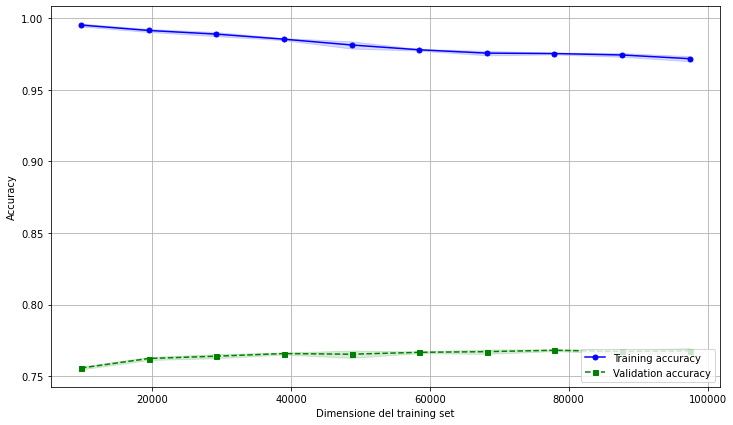

In [132]:
train_mean_rf = np.mean(train_scores_rf, axis=1)
train_std_rf = np.std(train_scores_rf, axis=1)
test_mean_rf = np.mean(test_scores_rf, axis=1)
test_std_rf = np.std(test_scores_rf, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(train_sizes_rf, train_mean_rf,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes_rf,
                 train_mean_rf + train_std_rf,
                 train_mean_rf - train_std_rf,
                 alpha=0.15, color='blue')

ax.plot(train_sizes_rf, test_mean_rf,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes_rf,
                 test_mean_rf + train_std_rf,
                 test_mean_rf - train_std_rf,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Dimensione del training set')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right')

In [134]:
print("accuracy:", round(train_mean_rf[-1], 4), "- val_accuracy:", round(test_mean_rf[-1], 4))

accuracy: 0.9716 - val_accuracy: 0.7677


val_accuracy: 0.7683


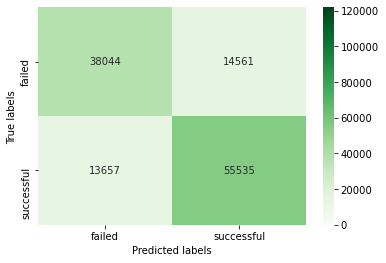

In [135]:
y_train_p_rf = cross_val_predict(rf_cls_bp, X_train_rf, y_train_rf, cv=StratifiedKFold(random_state=1, shuffle=True))
print('val_accuracy:', round(accuracy_score(y_train_rf, y_train_p_rf), 4))

cm_c_rf = confusion_matrix(y_train_rf, y_train_p_rf)
ax= plt.subplot()
sns.heatmap(cm_c_rf, annot=False, ax = ax, cmap="Greens", vmin=0, vmax=sum(sum(cm_c_rf))); #annot=True to annotate cells
sns.heatmap(cm_c_rf, annot=cm_c_rf, fmt="", cbar=False, cmap="Greens", vmin=0, vmax=sum(sum(cm_c_rf)))

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
#ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['failed', 'successful']); ax.yaxis.set_ticklabels(['failed', 'successful']);


### Test result

In [141]:
rf_cls_bp.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_depth=48, n_estimators=300, n_jobs=-1,
                       random_state=1)

Accuracy SCore 0.7703256704980843
F1 SCore 0.7702816571327751
Precision Score 0.7702403582706459
Recall SCore 0.7703256704980843


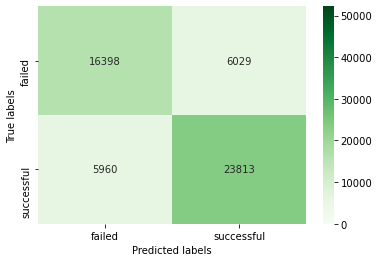

In [146]:
y_pred_rf = rf_cls_bp.predict(X_test_rf)
print("Accuracy SCore", accuracy_score(y_test_rf, y_pred_rf))
print("F1 SCore", f1_score(y_test_rf, y_pred_rf, average='weighted'))
print("Precision Score", precision_score(y_test_rf, y_pred_rf, average='weighted'))
print("Recall SCore", recall_score(y_test_rf, y_pred_rf, average='weighted'))
cm_rf = confusion_matrix(y_test_rf, y_pred_rf)
ax= plt.subplot()
sns.heatmap(cm_rf, annot=False, ax = ax, cmap="Greens", vmin=0, vmax=sum(sum(cm_rf))); #annot=True to annotate cells
sns.heatmap(cm_rf, annot=cm_rf, fmt="", cbar=False, cmap="Greens", vmin=0, vmax=sum(sum(cm_rf)))

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
#ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['failed', 'successful']); ax.yaxis.set_ticklabels(['failed', 'successful']);

## Neural network

In [9]:
data_preprocessing_NN = ColumnTransformer([
    ('features_categorical', OneHotEncoder(sparse=False), features_categorical),
    ('numeric_robust', RobustScaler(), features_robust),
    ('feature_standard', StandardScaler(), features_standard)
],
    remainder = 'passthrough'
)

In [10]:
fm2 = data_preprocessing_NN.fit_transform(ks1)
print(type(fm2), fm2.shape)

<class 'numpy.ndarray'> (173997, 387)


In [11]:
X_trainNN, X_testNN, y_trainNN, y_testNN = train_test_split(fm2, ks_label1, test_size=0.3, random_state=45)
X_trainNN.shape, y_trainNN.shape, X_testNN.shape, y_testNN.shape

((121797, 387), (121797,), (52200, 387), (52200,))

In [12]:
def build_model(n_neurons1=300, n_neurons2=200, n_neurons3=100, n_neurons4=50, n_neurons5=10, optimizer='adam', loss='binary_crossentropy', input_shape=[387]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    model.add(keras.layers.Dense(n_neurons1, activation="relu"))
    model.add(keras.layers.Dense(n_neurons2, activation="relu"))
    model.add(keras.layers.Dense(n_neurons3, activation="relu"))
    model.add(keras.layers.Dense(n_neurons4, activation="relu"))
    model.add(keras.layers.Dense(n_neurons5, activation="relu"))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss=loss, optimizer=optimizer,
                 metrics =  ['accuracy'])
    return model

### Randomized search

In [69]:
keras_NN = keras.wrappers.scikit_learn.KerasClassifier(build_model)

#### 1

In [70]:
param_grid_NN = [
    {"n_neurons1": [150, 300, 450],
     "n_neurons2": [100, 200, 300],
     "n_neurons3": [50, 100, 150],
     "n_neurons4": [25, 50, 75],
     "n_neurons5": [5, 10, 15],
     "optimizer": ['SGD', 'Adam', 'AdaDelta']     
    }
]

rand_search_NN = RandomizedSearchCV(keras_NN, 
                           param_distributions= param_grid_NN,
                           cv=5,
                           n_jobs=-1,
                           scoring=['f1','accuracy'],
                           refit = 'f1'
                          )

In [71]:
rand_search_NN.fit(X_trainNN, y_trainNN, epochs=50,
                  validation_split=0.3,
                  callbacks=[keras.callbacks.EarlyStopping(patience=4)],
                  verbose = 0
                 )

RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000271A2FFD7F0>,
                   n_jobs=-1,
                   param_distributions=[{'n_neurons1': [150, 300, 450],
                                         'n_neurons2': [100, 200, 300],
                                         'n_neurons3': [50, 100, 150],
                                         'n_neurons4': [25, 50, 75],
                                         'n_neurons5': [5, 10, 15],
                                         'optimizer': ['SGD', 'Adam',
                                                       'AdaDelta']}],
                   refit='f1', scoring=['f1', 'accuracy'])

In [72]:
print('best score: ',rand_search_NN.best_score_)
print('best params: ',rand_search_NN.best_params_)

best score:  0.7924555570290733
best params:  {'optimizer': 'SGD', 'n_neurons5': 5, 'n_neurons4': 50, 'n_neurons3': 50, 'n_neurons2': 200, 'n_neurons1': 300}


#### 2

In [73]:
rand_search_NN1 = RandomizedSearchCV(keras_NN, 
                           param_distributions= param_grid_NN,
                           cv=5,
                           n_jobs=-1,
                           scoring=['f1','accuracy'],
                           refit = 'f1'
                          )

In [74]:
rand_search_NN1.fit(X_trainNN, y_trainNN, epochs=50,
                  validation_split=0.3,
                  callbacks=[keras.callbacks.EarlyStopping(patience=4)],
                  verbose = 0
                 )

RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000271A2FFD7F0>,
                   n_jobs=-1,
                   param_distributions=[{'n_neurons1': [150, 300, 450],
                                         'n_neurons2': [100, 200, 300],
                                         'n_neurons3': [50, 100, 150],
                                         'n_neurons4': [25, 50, 75],
                                         'n_neurons5': [5, 10, 15],
                                         'optimizer': ['SGD', 'Adam',
                                                       'AdaDelta']}],
                   refit='f1', scoring=['f1', 'accuracy'])

In [75]:
print('best score: ',rand_search_NN1.best_score_)
print('best params: ',rand_search_NN1.best_params_)

best score:  0.7912723672738734
best params:  {'optimizer': 'Adam', 'n_neurons5': 10, 'n_neurons4': 25, 'n_neurons3': 150, 'n_neurons2': 200, 'n_neurons1': 150}


#### 3

In [76]:
param_grid_NN2 = [
    {"n_neurons1": [150, 200, 100],
     "n_neurons2": [400, 200, 300],
     "n_neurons3": [50, 100, 150],
     "n_neurons4": [25, 50, 75],
     "n_neurons5": [5, 10, 15],
     "optimizer": ['SGD', 'Adam', 'AdaDelta']     
    }
]

rand_search_NN2 = RandomizedSearchCV(keras_NN, 
                           param_distributions= param_grid_NN2,
                           cv=5,
                           n_jobs=-1,
                           scoring=['f1','accuracy'],
                           refit = 'f1'
                          )

In [77]:
rand_search_NN2.fit(X_trainNN, y_trainNN, epochs=50,
                  validation_split=0.3,
                  callbacks=[keras.callbacks.EarlyStopping(patience=4)],
                  verbose = 0
                 )

RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000271A2FFD7F0>,
                   n_jobs=-1,
                   param_distributions=[{'n_neurons1': [150, 200, 100],
                                         'n_neurons2': [400, 200, 300],
                                         'n_neurons3': [50, 100, 150],
                                         'n_neurons4': [25, 50, 75],
                                         'n_neurons5': [5, 10, 15],
                                         'optimizer': ['SGD', 'Adam',
                                                       'AdaDelta']}],
                   refit='f1', scoring=['f1', 'accuracy'])

In [78]:
print('best score: ',rand_search_NN2.best_score_)
print('best params: ',rand_search_NN2.best_params_)

best score:  0.7957274592622037
best params:  {'optimizer': 'SGD', 'n_neurons5': 10, 'n_neurons4': 75, 'n_neurons3': 50, 'n_neurons2': 200, 'n_neurons1': 200}


### Utilizzo best_params

In [79]:
model_bp = keras.models.Sequential([
    keras.layers.Input(shape=(X_trainNN.shape[1:])),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(75, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
    ])

model_bp.compile(loss = 'binary_crossentropy',
              optimizer = 'SGD',
              metrics =  ['accuracy']
             )

history_bp = model_bp.fit(X_trainNN, y_trainNN,
                    epochs=50,
                    batch_size=None,
                    validation_split=0.3,
                    callbacks=[keras.callbacks.EarlyStopping(patience=4)]
         )

Epoch 1/50
2665/2665 [==============================] - 4s 1ms/step - loss: 0.6453 - accuracy: 0.6287 - val_loss: 0.5276 - val_accuracy: 0.7254
Epoch 2/50
2665/2665 [==============================] - 4s 1ms/step - loss: 0.5019 - accuracy: 0.7405 - val_loss: 0.4670 - val_accuracy: 0.7515
Epoch 3/50
2665/2665 [==============================] - 4s 1ms/step - loss: 0.4569 - accuracy: 0.7600 - val_loss: 0.4473 - val_accuracy: 0.7649
Epoch 4/50
2665/2665 [==============================] - 3s 1ms/step - loss: 0.4478 - accuracy: 0.7650 - val_loss: 0.4486 - val_accuracy: 0.7637
Epoch 5/50
2665/2665 [==============================] - 4s 1ms/step - loss: 0.4403 - accuracy: 0.7687 - val_loss: 0.4422 - val_accuracy: 0.7684
Epoch 6/50
2665/2665 [==============================] - 4s 1ms/step - loss: 0.4399 - accuracy: 0.7703 - val_loss: 0.4468 - val_accuracy: 0.7625
Epoch 7/50
2665/2665 [==============================] - 4s 1ms/step - loss: 0.4387 - accuracy: 0.7713 - val_loss: 0.4523 - val_accuracy:

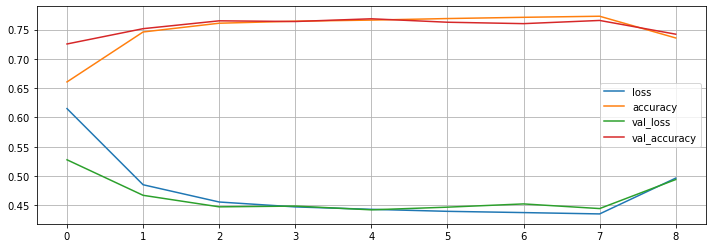

In [80]:
pd.DataFrame(history_bp.history).plot(figsize=(12,4))
plt.grid(True)

### Test result

In [81]:
y_pred_NN = (model_bp.predict(X_testNN) > 0.5).astype("int32")
print("Accuracy SCore", accuracy_score(y_testNN, y_pred_NN))
print("F1 SCore", f1_score(y_testNN, y_pred_NN, average='weighted'))
print("Precision Score", precision_score(y_testNN, y_pred_NN, average='weighted'))
print("Recall SCore", recall_score(y_testNN, y_pred_NN, average='weighted'))
print("Confusion Matrix \n", confusion_matrix(y_testNN, y_pred_NN))

Accuracy SCore 0.7369348659003832
F1 SCore 0.7381541073399956
Precision Score 0.7432827719245263
Recall SCore 0.7369348659003832
Confusion Matrix 
 [[16907  5520]
 [ 8212 21561]]


### Tune manuale

#### 1

In [82]:
model1 = keras.models.Sequential([
    keras.layers.Input(shape=(X_trainNN.shape[1:])),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
    ])

model1.compile(loss = 'binary_crossentropy',
              optimizer = 'sgd',
              metrics =  ['accuracy']
             )

history1 = model1.fit(X_trainNN, y_trainNN,
                    epochs=50,
                    batch_size=None,
                    validation_split=0.3,
                    callbacks=[keras.callbacks.EarlyStopping(patience=6)]
         )

Epoch 1/50
2665/2665 [==============================] - 5s 2ms/step - loss: 0.6449 - accuracy: 0.6333 - val_loss: 0.5441 - val_accuracy: 0.7102
Epoch 2/50
2665/2665 [==============================] - 4s 1ms/step - loss: 0.5128 - accuracy: 0.7371 - val_loss: 0.5637 - val_accuracy: 0.7050
Epoch 3/50
2665/2665 [==============================] - 4s 1ms/step - loss: 0.4612 - accuracy: 0.7584 - val_loss: 0.4765 - val_accuracy: 0.7463
Epoch 4/50
2665/2665 [==============================] - 4s 1ms/step - loss: 0.4463 - accuracy: 0.7669 - val_loss: 0.4640 - val_accuracy: 0.7569
Epoch 5/50
2665/2665 [==============================] - 4s 1ms/step - loss: 0.4400 - accuracy: 0.7704 - val_loss: 0.4509 - val_accuracy: 0.7606
Epoch 6/50
2665/2665 [==============================] - 4s 1ms/step - loss: 0.4390 - accuracy: 0.7693 - val_loss: 0.4732 - val_accuracy: 0.7460
Epoch 7/50
2665/2665 [==============================] - 4s 1ms/step - loss: 0.4351 - accuracy: 0.7751 - val_loss: 0.4449 - val_accuracy:

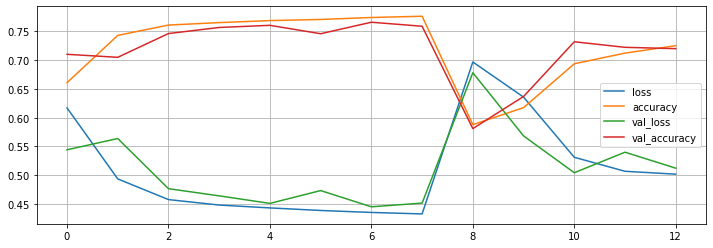

In [83]:
pd.DataFrame(history1.history).plot(figsize=(12,4))
plt.grid(True)

In [84]:
y_pred_NN1 = (model1.predict(X_testNN) > 0.5).astype("int32")
print("Accuracy SCore", accuracy_score(y_testNN, y_pred_NN1))
print("F1 SCore", f1_score(y_testNN, y_pred_NN1, average='weighted'))
print("Precision Score", precision_score(y_testNN, y_pred_NN1, average='weighted'))
print("Recall SCore", recall_score(y_testNN, y_pred_NN1, average='weighted'))
print("Confusion Matrix \n", confusion_matrix(y_testNN, y_pred_NN1))

Accuracy SCore 0.7172222222222222
F1 SCore 0.7121917354158398
Precision Score 0.7831130038770354
Recall SCore 0.7172222222222222
Confusion Matrix 
 [[20809  1618]
 [13143 16630]]


#### 11

In [85]:
model11 = keras.models.Sequential([
    keras.layers.Input(shape=(X_trainNN.shape[1:])),
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
    ])

model11.compile(loss = 'binary_crossentropy',
              optimizer = 'sgd',
              metrics =  ['accuracy']
             )

history11 = model11.fit(X_trainNN, y_trainNN,
                    epochs=50,
                    batch_size=None,
                    validation_split=0.3
         )

Epoch 1/50
2665/2665 [==============================] - 6s 2ms/step - loss: 0.6503 - accuracy: 0.6264 - val_loss: 0.5820 - val_accuracy: 0.7007
Epoch 2/50
2665/2665 [==============================] - 5s 2ms/step - loss: 0.5071 - accuracy: 0.7381 - val_loss: 0.4924 - val_accuracy: 0.7278
Epoch 3/50
2665/2665 [==============================] - 5s 2ms/step - loss: 0.4578 - accuracy: 0.7601 - val_loss: 0.4541 - val_accuracy: 0.7617
Epoch 4/50
2665/2665 [==============================] - 5s 2ms/step - loss: 0.4458 - accuracy: 0.7666 - val_loss: 0.4432 - val_accuracy: 0.7647
Epoch 5/50
2665/2665 [==============================] - 5s 2ms/step - loss: 0.4402 - accuracy: 0.7700 - val_loss: 0.4431 - val_accuracy: 0.7673
Epoch 6/50
2665/2665 [==============================] - 5s 2ms/step - loss: 0.4380 - accuracy: 0.7722 - val_loss: 0.4424 - val_accuracy: 0.7673
Epoch 7/50
2665/2665 [==============================] - 5s 2ms/step - loss: 0.4308 - accuracy: 0.7773 - val_loss: 0.4442 - val_accuracy:

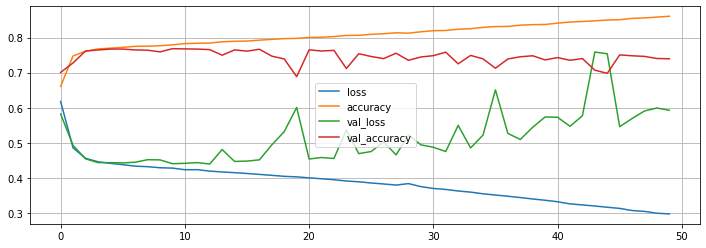

In [86]:
pd.DataFrame(history11.history).plot(figsize=(12,4))
plt.grid(True)

In [87]:
y_pred_NN11 = (model11.predict(X_testNN) > 0.5).astype("int32")
print("Accuracy SCore", accuracy_score(y_testNN, y_pred_NN11))
print("F1 SCore", f1_score(y_testNN, y_pred_NN11, average='weighted'))
print("Precision Score", precision_score(y_testNN, y_pred_NN11, average='weighted'))
print("Recall SCore", recall_score(y_testNN, y_pred_NN11, average='weighted'))
print("Confusion Matrix \n", confusion_matrix(y_testNN, y_pred_NN11))

Accuracy SCore 0.7398659003831418
F1 SCore 0.7399189913579708
Precision Score 0.7399751530789588
Recall SCore 0.7398659003831418
Confusion Matrix 
 [[15675  6752]
 [ 6827 22946]]


#### 2

In [88]:
model2 = keras.models.Sequential([
    keras.layers.Input(shape=(X_trainNN.shape[1:])),
    keras.layers.Dense(500, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(50, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(1, activation="sigmoid")])
model2.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics =  ['accuracy'])
history2 = model2.fit(X_trainNN, y_trainNN,
                    epochs=50,
                    batch_size=None,
                    validation_split=0.3,
                    callbacks=[keras.callbacks.EarlyStopping(patience=4)])

Epoch 1/50
2665/2665 [==============================] - 7s 2ms/step - loss: 0.6388 - accuracy: 0.7334 - val_loss: 0.4558 - val_accuracy: 0.7583
Epoch 2/50
2665/2665 [==============================] - 7s 2ms/step - loss: 0.4553 - accuracy: 0.7606 - val_loss: 0.4507 - val_accuracy: 0.7572
Epoch 3/50
2665/2665 [==============================] - 6s 2ms/step - loss: 0.4570 - accuracy: 0.7581 - val_loss: 0.4491 - val_accuracy: 0.7639
Epoch 4/50
2665/2665 [==============================] - 7s 2ms/step - loss: 0.4392 - accuracy: 0.7691 - val_loss: 0.4491 - val_accuracy: 0.7629
Epoch 5/50
2665/2665 [==============================] - 6s 2ms/step - loss: 0.4431 - accuracy: 0.7675 - val_loss: 0.4429 - val_accuracy: 0.7670
Epoch 6/50
2665/2665 [==============================] - 6s 2ms/step - loss: 0.4522 - accuracy: 0.7690 - val_loss: 0.4407 - val_accuracy: 0.7661
Epoch 7/50
2665/2665 [==============================] - 6s 2ms/step - loss: 0.4333 - accuracy: 0.7736 - val_loss: 0.4418 - val_accuracy:

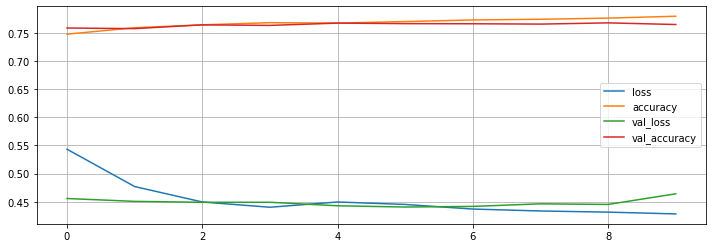

In [89]:
pd.DataFrame(history2.history).plot(figsize=(12,4))
plt.grid(True)

Accuracy SCore 0.7643295019157088
F1 SCore 0.7654850415961921
Precision Score 0.7724093049480544
Recall SCore 0.7643295019157088


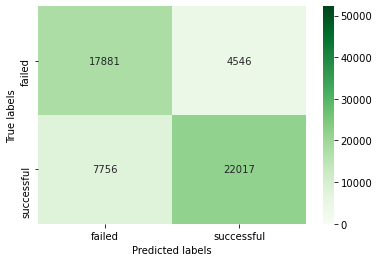

In [21]:
y_pred_NN2 = (model2.predict(X_testNN) > 0.5).astype("int32")
print("Accuracy SCore", accuracy_score(y_testNN, y_pred_NN2))
print("F1 SCore", f1_score(y_testNN, y_pred_NN2, average='weighted'))
print("Precision Score", precision_score(y_testNN, y_pred_NN2, average='weighted'))
print("Recall SCore", recall_score(y_testNN, y_pred_NN2, average='weighted'))
cm_NN = confusion_matrix(y_testNN, y_pred_NN2)
ax= plt.subplot()
sns.heatmap(cm_NN, annot=False, ax = ax, cmap="Greens", vmin=0, vmax=sum(sum(cm_NN)));
sns.heatmap(cm_NN, annot=cm_NN, fmt="", cbar=False, cmap="Greens", vmin=0, vmax=sum(sum(cm_NN)))


ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');  
ax.xaxis.set_ticklabels(['failed', 'successful']); ax.yaxis.set_ticklabels(['failed', 'successful']);

#### 22

In [91]:
model22 = keras.models.Sequential([
    keras.layers.Input(shape=(X_trainNN.shape[1:])),
    keras.layers.Dense(500, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(50, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(1, activation="sigmoid")
    ])

model22.compile(loss = 'binary_crossentropy',
              optimizer = 'sgd',
              metrics =  ['accuracy']
             )

history22 = model22.fit(X_trainNN, y_trainNN,
                    epochs=50,
                    batch_size=None,
                    validation_split=0.3
         )

Epoch 1/50
2665/2665 [==============================] - 6s 2ms/step - loss: 0.6098 - accuracy: 0.6556 - val_loss: 0.5520 - val_accuracy: 0.7027
Epoch 2/50
2665/2665 [==============================] - 5s 2ms/step - loss: 0.5018 - accuracy: 0.7371 - val_loss: 0.4596 - val_accuracy: 0.7562
Epoch 3/50
2665/2665 [==============================] - 5s 2ms/step - loss: 0.4594 - accuracy: 0.7597 - val_loss: 0.4545 - val_accuracy: 0.7638
Epoch 4/50
2665/2665 [==============================] - 5s 2ms/step - loss: 0.4508 - accuracy: 0.7659 - val_loss: 0.4610 - val_accuracy: 0.7531
Epoch 5/50
2665/2665 [==============================] - 5s 2ms/step - loss: 0.4711 - accuracy: 0.7581 - val_loss: 0.4686 - val_accuracy: 0.7605
Epoch 6/50
2665/2665 [==============================] - 5s 2ms/step - loss: 0.4643 - accuracy: 0.7596 - val_loss: 0.4667 - val_accuracy: 0.7564
Epoch 7/50
2665/2665 [==============================] - 5s 2ms/step - loss: 0.4498 - accuracy: 0.7681 - val_loss: 0.4527 - val_accuracy:

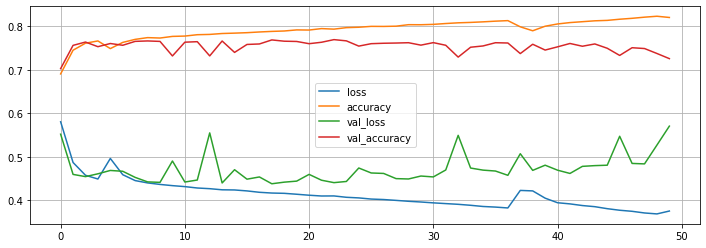

In [92]:
pd.DataFrame(history22.history).plot(figsize=(12,4))
plt.grid(True)

In [93]:
y_pred_NN22 = (model22.predict(X_testNN) > 0.5).astype("int32")
print("Accuracy SCore", accuracy_score(y_testNN, y_pred_NN22))
print("F1 SCore", f1_score(y_testNN, y_pred_NN22, average='weighted'))
print("Precision Score", precision_score(y_testNN, y_pred_NN22, average='weighted'))
print("Recall SCore", recall_score(y_testNN, y_pred_NN22, average='weighted'))
print("Confusion Matrix \n", confusion_matrix(y_testNN, y_pred_NN22))

Accuracy SCore 0.7258812260536398
F1 SCore 0.7267732743158025
Precision Score 0.7288575942259623
Recall SCore 0.7258812260536398
Confusion Matrix 
 [[16021  6406]
 [ 7903 21870]]


#### 3

In [94]:
model3 = keras.models.Sequential([
    keras.layers.Input(shape=(X_trainNN.shape[1:])),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
    ])

model3.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics =  ['accuracy']
             )

history3 = model3.fit(X_trainNN, y_trainNN,
                    epochs=50,
                    batch_size=None,
                    validation_split=0.3,
                    callbacks=[keras.callbacks.EarlyStopping(patience=4)]
         )

Epoch 1/50
2665/2665 [==============================] - 5s 2ms/step - loss: 0.4905 - accuracy: 0.7365 - val_loss: 0.4420 - val_accuracy: 0.7674
Epoch 2/50
2665/2665 [==============================] - 4s 2ms/step - loss: 0.4385 - accuracy: 0.7699 - val_loss: 0.4341 - val_accuracy: 0.7694
Epoch 3/50
2665/2665 [==============================] - 4s 2ms/step - loss: 0.4276 - accuracy: 0.7770 - val_loss: 0.4340 - val_accuracy: 0.7724
Epoch 4/50
2665/2665 [==============================] - 4s 2ms/step - loss: 0.4169 - accuracy: 0.7838 - val_loss: 0.4369 - val_accuracy: 0.7686
Epoch 5/50
2665/2665 [==============================] - 4s 2ms/step - loss: 0.4104 - accuracy: 0.7884 - val_loss: 0.4389 - val_accuracy: 0.7652
Epoch 6/50
2665/2665 [==============================] - 4s 2ms/step - loss: 0.3972 - accuracy: 0.7982 - val_loss: 0.4464 - val_accuracy: 0.7652
Epoch 7/50
2665/2665 [==============================] - 4s 2ms/step - loss: 0.3840 - accuracy: 0.8070 - val_loss: 0.4584 - val_accuracy:

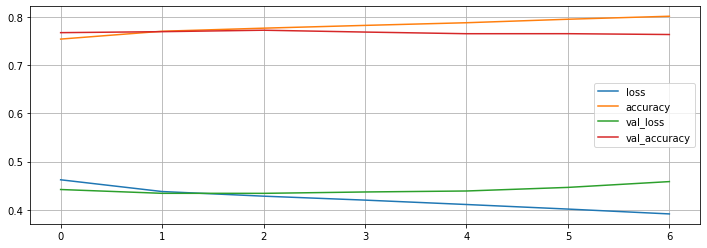

In [95]:
pd.DataFrame(history3.history).plot(figsize=(12,4))
plt.grid(True)

In [96]:
y_pred_NN3 = (model3.predict(X_testNN) > 0.5).astype("int32")
print("Accuracy SCore", accuracy_score(y_testNN, y_pred_NN3))
print("F1 SCore", f1_score(y_testNN, y_pred_NN3, average='weighted'))
print("Precision Score", precision_score(y_testNN, y_pred_NN3, average='weighted'))
print("Recall SCore", recall_score(y_testNN, y_pred_NN3, average='weighted'))
print("Confusion Matrix \n", confusion_matrix(y_testNN, y_pred_NN3))

Accuracy SCore 0.7609770114942529
F1 SCore 0.7612500364253222
Precision Score 0.7616331759697886
Recall SCore 0.7609770114942529
Confusion Matrix 
 [[16410  6017]
 [ 6460 23313]]


#### 4

In [97]:
model4 = keras.models.Sequential([
    keras.layers.Input(shape=(X_trainNN.shape[1:])),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
    ])
model4.compile(loss = 'binary_crossentropy',
              optimizer = keras.optimizers.SGD(lr=1e-3),
              metrics =  ['accuracy']
             )
history4 = model4.fit(X_trainNN, y_trainNN,
                    epochs=50,
                    batch_size=None,
                    validation_split=0.3,
                    callbacks=[keras.callbacks.EarlyStopping(patience=4)]
         )

Epoch 1/50
2665/2665 [==============================] - 4s 2ms/step - loss: 0.6739 - accuracy: 0.6056 - val_loss: 0.6388 - val_accuracy: 0.6467
Epoch 2/50
2665/2665 [==============================] - 4s 1ms/step - loss: 0.6387 - accuracy: 0.6435 - val_loss: 0.6237 - val_accuracy: 0.6561
Epoch 3/50
2665/2665 [==============================] - 4s 1ms/step - loss: 0.6262 - accuracy: 0.6525 - val_loss: 0.6107 - val_accuracy: 0.6665
Epoch 4/50
2665/2665 [==============================] - 4s 1ms/step - loss: 0.6109 - accuracy: 0.6680 - val_loss: 0.5947 - val_accuracy: 0.6836
Epoch 5/50
2665/2665 [==============================] - 4s 1ms/step - loss: 0.5927 - accuracy: 0.6847 - val_loss: 0.5736 - val_accuracy: 0.7008
Epoch 6/50
2665/2665 [==============================] - 4s 1ms/step - loss: 0.5732 - accuracy: 0.6996 - val_loss: 0.5478 - val_accuracy: 0.7173
Epoch 7/50
2665/2665 [==============================] - 4s 1ms/step - loss: 0.5562 - accuracy: 0.7125 - val_loss: 0.5418 - val_accuracy:

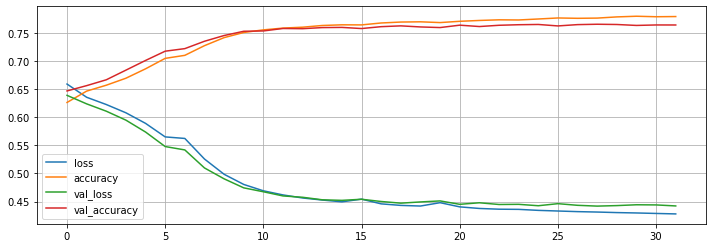

In [98]:
pd.DataFrame(history4.history).plot(figsize=(12,4))
plt.grid(True)

In [99]:
y_pred_NN4 = (model4.predict(X_testNN) > 0.5).astype("int32")
print("Accuracy SCore", accuracy_score(y_testNN, y_pred_NN4))
print("F1 SCore", f1_score(y_testNN, y_pred_NN4, average='weighted'))
print("Precision Score", precision_score(y_testNN, y_pred_NN4, average='weighted'))
print("Recall SCore", recall_score(y_testNN, y_pred_NN4, average='weighted'))
print("Confusion Matrix \n", confusion_matrix(y_testNN, y_pred_NN4))

Accuracy SCore 0.7629693486590038
F1 SCore 0.7639848669689112
Precision Score 0.7679192324571159
Recall SCore 0.7629693486590038
Confusion Matrix 
 [[17383  5044]
 [ 7329 22444]]


#### 5

In [100]:
model5 = keras.models.Sequential([
    keras.layers.Input(shape=(X_trainNN.shape[1:])),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation="sigmoid")
    ])

model5.compile(loss = 'binary_crossentropy',
              optimizer = 'sgd',
              metrics =  ['accuracy']
             )

history5 = model5.fit(X_trainNN, y_trainNN,
                    epochs=50,
                    batch_size=None,
                    validation_split=0.3,
                    callbacks=[keras.callbacks.EarlyStopping(patience=4)]
         )

Epoch 1/50
2665/2665 [==============================] - 8s 2ms/step - loss: 0.5617 - accuracy: 0.6976 - val_loss: 0.5153 - val_accuracy: 0.7361
Epoch 2/50
2665/2665 [==============================] - 6s 2ms/step - loss: 0.4672 - accuracy: 0.7550 - val_loss: 0.5100 - val_accuracy: 0.7400
Epoch 3/50
2665/2665 [==============================] - 6s 2ms/step - loss: 0.4595 - accuracy: 0.7566 - val_loss: 0.5121 - val_accuracy: 0.7373
Epoch 4/50
2665/2665 [==============================] - 6s 2ms/step - loss: 0.4560 - accuracy: 0.7604 - val_loss: 0.5028 - val_accuracy: 0.7394
Epoch 5/50
2665/2665 [==============================] - 6s 2ms/step - loss: 0.4476 - accuracy: 0.7652 - val_loss: 0.5026 - val_accuracy: 0.7412
Epoch 6/50
2665/2665 [==============================] - 6s 2ms/step - loss: 0.4454 - accuracy: 0.7651 - val_loss: 0.5030 - val_accuracy: 0.7411
Epoch 7/50
2665/2665 [==============================] - 6s 2ms/step - loss: 0.4390 - accuracy: 0.7694 - val_loss: 0.5128 - val_accuracy:

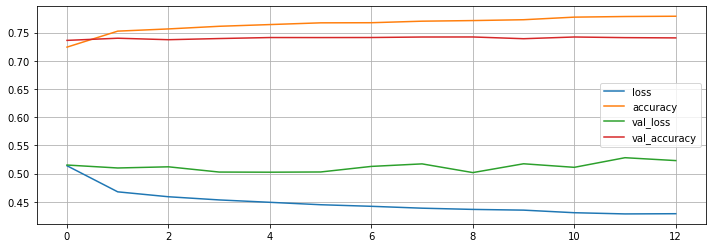

In [101]:
pd.DataFrame(history5.history).plot(figsize=(12,4))
plt.grid(True)

In [102]:
y_pred_NN4 = (model4.predict(X_testNN) > 0.5).astype("int32")
print("Accuracy SCore", accuracy_score(y_testNN, y_pred_NN4))
print("F1 SCore", f1_score(y_testNN, y_pred_NN4, average='weighted'))
print("Precision Score", precision_score(y_testNN, y_pred_NN4, average='weighted'))
print("Recall SCore", recall_score(y_testNN, y_pred_NN4, average='weighted'))
print("Confusion Matrix \n", confusion_matrix(y_testNN, y_pred_NN4))

Accuracy SCore 0.7629693486590038
F1 SCore 0.7639848669689112
Precision Score 0.7679192324571159
Recall SCore 0.7629693486590038
Confusion Matrix 
 [[17383  5044]
 [ 7329 22444]]
